# BS Example

A beam switch (BS) spectrum with SEQUOIA is obtained by switching between two pixels in the array.  Thus, we always have one of the two beams on the source and there is no time lost for observation of a reference.  This results in a square root of two improvement in noise.

The BS approach is most appropriate for point sources where the small offset between pixels is sufficient to get a good "OFF" measurement.

Usually, we track pixel 10 and switch the telescope to pixel 8 for the reference observation.  This allows us to read data from only one of the roach boards to do the reduction of the spectrum. 

### Necessary Imports

In [1]:
# Python Imports
import numpy as np
import matplotlib.pyplot as pl

# Line Data Reduction Imports
from lmtslr.spec.spec import *
from lmtslr.ifproc.ifproc import *
from lmtslr.viewer.spec_viewer import *

from lmtslr.reduction.line_reduction import *



### Setup parameters for the reduction

In [2]:
# set all parameters to control the reduction and plot                                                                   

data_path = '/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/'
obsnum = 83057
pixel_number = 10

# calibration options
use_calibration = True
tsys = 100.

# designate pixels for the BS reduction                                                                                  
list_of_pixels = [8,10]
bank = 0

# baseline options
baseline_order = 0
plot_limits = [20,60,-10,300]
baseline_regions = [[-100,20],[60,200]]
line_integral_regions = [[25,55]]




### Read and reduce the spectrum

The `read-obsnum_bs` function follows the procedure of `read_obsnum_ps` used to produce PS spectra with the exception that the role of Main and Reference are reversed for the first pixel in the pixel list.  

In [3]:
I, S = read_obsnum_bs(obsnum, list_of_pixels, bank, use_calibration, tsys=tsys, path=data_path)

found roach2_83057_0_1_W-Hya_2019-04-26_045336.nc
append roach2_83057_0_1_W-Hya_2019-04-26_045336.nc
found ifproc_2019-04-26_083057_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  8
/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/ifproc/ifproc_2019-04-26_083057_00_0001.nc does not have map parameters
83057 is a Bs observation
read_roach /Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/spectrometer/roach2/roach2_83057_0_1_W-Hya_2019-04-26_045336.nc
r:2 inp:0 pix:8 to:-0.030000
r:2 inp:2 pix:10 to:-0.030000
found roach2_83053_0_1_W-Hya_2019-04-26_045111.nc
append roach2_83053_0_1_W-Hya_2019-04-26_045111.nc
found ifproc_2019-04-26_083053_00_0001.nc
before read npix
from pixels npix = 16
from xlen npix = 16
TRACKING Sequoia PIXEL  10
/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/ifproc/ifproc_2019-04-26_083053_00_0001.nc does not have map paramet

/Users/schloerb/anaconda/envs/lmtslr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/schloerb/Desktop/LMT/SPECTRALLINE/lmtslr/spec/spec.py:145: RuntimeWarning: invalid value encountered in true_divide
  ps_list[i,:] = (self.reference_spectra[i,:]-self.main_spectra[i,:])/self.main_spectra[i,:]
/Users/schloerb/Desktop/LMT/SPECTRALLINE/lmtslr/spec/spec.py:142: RuntimeWarning: invalid value encountered in true_divide
  ps_list[i,:] = (self.main_spectra[i,:]-self.reference_spectra[i,:])/self.reference_spectra[i,:]


### Create LineData objects for analysis

The following code block creates individual `LineData` objects for the spectra on the Main position (pixel 10) and the Reference position (pixel 8).  The individual spectra are plotted.

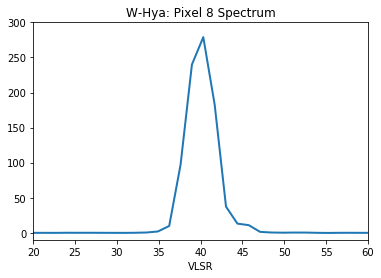

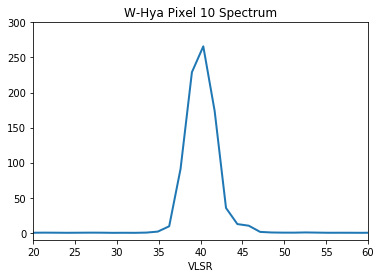

In [4]:
LD_0 = LineData(I,bank,S.nchan,S.bandwidth,S.roach[0].ps_spectrum)
LD_1 = LineData(I,bank,S.nchan,S.bandwidth,S.roach[1].ps_spectrum)

# select "V Source" option since this is a comet spectrum
LD_0.x_vlsr()
LD_1.x_vlsr()

# make a plot of the two spectra
pl.figure()
pl.plot(LD_0.xarray,LD_0.yarray)
pl.axis(plot_limits)
pl.xlabel(LD_0.xname)
pl.title('%s: Pixel %d Spectrum'%(I.source,list_of_pixels[0]));

pl.figure()
pl.plot(LD_1.xarray,LD_1.yarray)
pl.axis(plot_limits)
pl.xlabel(LD_1.xname)
pl.title('%s Pixel %d Spectrum'%(I.source,list_of_pixels[1]));





### Forming the BS Spectrum

We can also combine the individual spectra from the reduction to derive the BS result.  We create a single `LineData` object with the result. 

In [ ]:
# create a LineData object with the BS spectrum
BS_LineData = LineData(I,bank,S.nchan,S.bandwidth,(S.roach[0].ps_spectrum + S.roach[1].ps_spectrum)/2.)

# plot the combined result
pl.plot(BS_LineData.xarray,BS_LineData.yarray)
pl.axis(plot_limits)
pl.xlabel(BS_LineData.xname)
pl.title('%s: BS Spectrum with Pixels %d and %d'%(I.source,list_of_pixels[0],list_of_pixels[1]))





In [ ]:
# create Line obeject to use spectral line methods
BS_Line = BS_LineData.line()

# fit baseline
blist, nb = BS_Line.xlist(baseline_regions)
BS_Line.baseline(blist,nb,baseline_order)

# compute "line" parameters
llist, nl = BS_Line.xlist(line_integral_regions)
BS_Line.line_stats(llist,nl)

# print the results
print('Results for %s %d'%(I.source,I.obsnum))
print('YMAX = %f  YINT = %f  XMEAN = %f  XMAX = %s'%(BS_Line.ymax,BS_Line.yint,BS_Line.xmean,BS_Line.xmax))
print('RMS = %f'%(BS_Line.rms))